# Exercise 3: Gaussian Process Factor Analysis (GPFA)

> The neural data have been generously provided by the laboratory of Prof. Krishna Shenoy at Stanford University. The data are to be used exclusively for educational purposes in this course.


This exercise has a few parts that will help you develop an intuition for how GPFA works.

**Section 1**: You will generate some synthetic data and then fit the parameters of a GPFA model to your synthetic data to see how well GPFA performs at discovering the true parameters underlying your data.
The synthetic data will come from you using a Gaussian Process to simulate the trajectory of a 1-dimensional latent state over time, and then generating activity traces for a few neurons that are modulated by the value of the latent state.

**Section 2**: You will investigate more complex simulated data driven by a higher dimensional latent space.
We'll look at how to determine the dimensionality of the latent space and how predicted latent states compare to the true ones. 

**Section 3**: You will perform a set of analysis steps very similar to what was done in [1] (the paper we read for Session 7, which develops GPFA), but using a different dataset.
Specifically, we'll be using the data from [3].

**Section 4**: Using the real data, you will compare PCA, factor analysis, and GPFA.

Once you have completed the exercise, please describe the results of your exercise, and your interpretation of the results *(suggested length: 450-650 words).*
Use figures to help describe your results; please embed the figures in your text description.
Questions for you to discuss in your write-up are also flagged with **TO-DO:**.

**Submit the write-up before noon on the day of the next session.**

Much of the crucial code is already implemented for you. Just follow the **TO-DO** signs to complete the problem set.

*Acknowledgements: This exercise was adapted by Ella Batty based on a previous version by Jasper Maniates-Selvin and Adam Lowet.*

[1] Yu BM, Cunningham JP, Santhanam G, Ryu SI, Shenoy KV, Sahani M. 2009. Gaussian-process factor analysis
for low-dimensional single-trial analysis of neural population activity. J. Neurophysiol. 102(1):614–35.
<br/>
[2] Lawlor PN, Perich MG, Miller L, Kording KP. 2018. Linear-nonlinear-time-warp-poisson models of neural activity. J. Comput. Neurosci. 45:173–91.
<br/>
[3] Yu, B. M., Kemere C., Santhanam, G., Afshar, A., Ryu, S. I., Meng, T.H., Sahani, M., & Shenoy, K.V. (2007) Mixture of trajectory models for neural decoding of goal-directed movements. Journal of Neurophysiology, 97(5), 3762-3780.

For your convenience, here are all the **TO-DO**s from throughout the exercise.
They will make more sense in context.

* Complete the  `generate_trajectories` function below to generate both the latent trajectories during each trial and the neural activity governed by those latent trajectories according to the GPFA equations in [1]. 
* Look at neural activity in trial 0 and describe the differences you observe between the first 4 neurons. Inspect equation 1, the data above, and your values for C, d, and R. Discuss how those parameters affect different aspects of the neural activity. Could you predict how much a neuron's activity is correlated with the latent trajectory from looking at the parameters? How? (You don't have to generate plots to demonstrate this, though you might want to do so if you're not sure of the answer.)
* Complete the code below to initialize the GPFA model with the true number of latents used to simulate the data, and fit it.
* In your write-up, discuss how the EM algorithm did at extracting the true parameters. What what we need to further reduce the error in the extracted parameters?
* Compare the true and predicted latent trajectories. There should be one major difference. Could you have seen this coming after observing the one major difference between the true and predicted parameters in Section 1.4? Explain what's going on in your write-up.
* Use code to find the number of trials and number of neurons contained in the spiking data (`spike_trains`).  How many latent trajectories were used to create the data? The latent trajectories are stored in (`latent_trajectories`). The time bin size is 50ms. How many time bins were used for the latent trajectories? 
* Complete the following code to get the log likelihood of the fit for the training and testing data. We will divide by the number of training and testing trials so we can directly compare these values.
* The predicted latents don't match the true latents. Did something go wrong or is this expected? Discuss in your write-up
* Complete the line that performs linear regression to combine the predicted latent trajectories to form each of the true latent trajectories (in `latent_trajectories`) on the first test trial. We'll look at the first 3 true latents.
*  Based on this, do the true and predicted latent trajectories seem to span the same 8-dimensional manifold or not? Explain why or why not. Discuss in your write-up.
*  How does the variance change across non-orthonormalized dimensions 1 through 8? How does it change across orthonormalized dimensions 1 through 8? Do you think the fitted model's non-orthonormalized dimension 1 would resemble the ground truth non-orthonormalized dimension 1? Do you think the fitted model's orthonormalized dimension 1 would resemble the ground truth orthonormalized dimension 1? Why or why not? Discuss in your write-up.
* What underlying dimensionality would you assume the neural data has based on these plots?  Do the log-likelihood and prediction errors give similar results? Why might you use one over the other? Discuss in your write-up.
* Do you find this visualization technique helpful for getting a handle on what the latent trajectories look like? Describe what you see - what happens over time and how does it vary by reach? Does it seem like the neural trajectories are different for different reaches? If so, are they well separated? That is, would you be able to tell what the reach direction was just from observing a single trial trajectory? Does the relationship of the mean neural trajectories relate to the relationship of the reach directions? Discuss in your write-up.
* Perform PCA and FA on the smoothed train spike data. Transform the test data and save the matrices as pc_transform and fa_transform.
* Compare the GPFA trajectories to the PCA and FA plots. What's the major visual difference (look at the individual trials, not the trial average)? What difference in the structure of the models explains the visual difference? Discuss in your write-up.
* From this plot, what can you conclude about the dimensionality of the latent state driving activity in the recorded neurons? Do the different models agree or disagree about this dimensionality? Which result do you think you should trust, and why? Discuss in your write-up.
* Why are we using prediction error here instead of log-likelihood? Discuss in your write-up.
* What is the optimal kernel width for this dataset?

## Setup

In [63]:
import copy
import pickle
from pathlib import Path

import ipywidgets as widgets
import matplotlib.pyplot as plt
import neo
import numpy as np
import quantities as pq
import scipy.io as sio
import scipy.ndimage
from elephant.gpfa import GPFA, gpfa_core, gpfa_util
from IPython.display import Image, display
from matplotlib import animation, rc
from scipy import linalg
from sklearn import linear_model
from sklearn.decomposition import PCA, FactorAnalysis

In [60]:
rc("animation", html="html5")

In [61]:
data_dir = Path("data", "NB316QC_Ex3_data")

## Section 1: Generate and fit synthetic data from a 1-dimensional latent space

With any complicated model, it's always a good idea to perform "model recovery": simulate data according to the generative model that you specify, and then run your model on those data to see if you can recover a close approximation to the ground-truth parameters.
We will start by running GPFA on low-dimensional simulated data.

### Section 1.1. Generate parameters for simulated data

In this section, we will create the parameters we will use to simulate data using the GPFA model from [1]. 

In the function below, `n_latents` is the dimensionality of the latent state, and `n_neurons` is the dimensionality of the observed state, which in this case is the number of neurons. We will use a latent state dimensionality of 1 and generate activity for 5 neurons. The function below takes those dimensionalities as arguments and generates random parameters governing the relationship between the latent and observed variables.

`C`, `d`, and `R` are defined by equation 1 in [1].

`gamma[i]` is related to $\tau_i^2$ from equation 3, but the model is parameterized slightly differently in this code such that `gamma` also includes the time scaling factor for the spacing between time bins. So, gamma[i] $= (\text{timeBinSize}^2 / \tau_i^2)$.

`eps` is $\sigma_{n,i}^2$ from equation 3 and is set to .001 instead of being determined randomly, same as is done in the paper.

We define a random seed so that the generated parameters are always the same. You can try different seeds if you want to see the behavior under different parameters, but please use the default random seed for generating plots for your write-up (so that all students will have the same output).

In [13]:
def create_GP_covariance_matrices(
    n_latents: int, eps: float, gamma: list[float]
) -> list[np.ndarray]:
    # Create covariance matrices for GP using the squared exponential kernel from Yu et al.
    K = []
    time_differences = np.tile(
        np.arange(1, n_time_bins + 1).reshape((n_time_bins, 1)), (1, n_time_bins)
    ) - np.tile(np.arange(1, n_time_bins + 1), (n_time_bins, 1))
    for i in range(n_latents):
        # `temp` is the term on the left of the `+` sign in equation 3
        # (but as a matrix for all t1, t2 pairs)
        temp = (1 - eps[i]) * np.exp(-gamma[i] / 2 * time_differences**2)

        # K_i has values given by equation 3 of Yu et al.
        K_i = temp + eps[i] * np.identity(time_differences.shape[0])
        K.append(K_i)

    return K

In [14]:
def rand_params_generator(
    n_latents: int, n_neurons: int, random_seed: int = 2
) -> tuple[dict[str, np.ndarray], list[np.ndarray]]:
    """Generate parameters to simulate data assuming a GPFA model

    Args:
      n_latents (int): number of latents underlying neural activity
      n_neurons (int): number of observed nuerons
      random_seed (float): random seed to set for reproducibility

    Returns:
      dict, list: dictionary containing all the parameters (keys are param names),
                list of covariance matrices for the GP for each latent

    """
    # Set random seed for reproducibility
    np.random.seed(seed=random_seed)

    # Create parameters we will estimate
    params = {}

    # gamma determines whether the latent trajectories oscillate quickly (large gammas) or vary more smoothly (small gammas)
    params["gamma"] = np.random.uniform(0.1, 0.3, n_latents).tolist()
    params["eps"] = 1e-3 * np.ones((n_latents,))

    params["d"] = 7 + np.random.normal(0, 1, size=(n_neurons,))
    params["C"] = np.random.normal(0, 1, size=(n_neurons, n_latents))
    params["R"] = np.diag(np.abs(np.random.normal(0, 0.4, n_neurons)))

    # Based on eps & gamma, create covariance matrices using eq. 3 from [1]
    K = create_GP_covariance_matrices(n_latents, params["eps"], params["gamma"])

    return params, K

In [15]:
# Set up hyperparameters
n_latents = 1
n_neurons = 5
n_time_bins = 100  # number of time bins of data to simulate per trial
time_bin_size = 0.02  # bin size in seconds
n_trials = 10  # number of trials we will simulate

# Create parameters
params, K = rand_params_generator(n_latents, n_neurons)
print(params)

{'gamma': [0.18719898042840075], 'eps': array([0.001]), 'd': array([7.04555144, 6.56516985, 5.04620359, 5.41311831, 5.92554448]), 'C': array([[-0.61722311],
       [-1.50100687],
       [ 0.8935898 ],
       [ 0.73954567],
       [-1.42356496]]), 'R': array([[0.4442911 , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.03543203, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.54169222, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.02330828, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.19203394]])}


### Section 1.2: Generate a latent space & neural trajectories

**TO-DO:** Complete the  `generate_trajectories` function below to generate both the latent trajectories during each trial and the neural activity governed by those latent trajectories according to the GPFA equations in [1]. 

Note: the neural activity we are generating here is the square-rooted binned spike counts. We'll convert to spike times later.

In [36]:
def generate_trajectories(
    params: dict[str, np.ndarray],
    K: list[np.ndarray],
    n_trials: int,
    n_latents: int,
    n_neurons: int,
    n_time_bins: int,
    random_seed: int = 3,
) -> tuple[np.ndarray, np.ndarray]:
    """Generate latent and neural trajectories given parameters

    Args:
      params (dict): dictionary containing all the parameters (keys are param names)
      K (list): list of covariance matrices for the GP for each latent
      n_trials (int): number of trials of data to simulate
      n_latents (int): number of latent dimensions to simulate
      n_neurons (int): number of neurons to simulate
      n_time_bins (int): number of time steps to simulate
      random_seed (float): random seed to set for reproducibility

    Returns:
      ndarray, ndarray: n_trials x n_latents x n_time_bins array containing latent trajectories,
                n_trials x n_neurons x n_time_bins array containing neural activity
    """
    np.random.seed(seed=random_seed)

    # Initialize storage arrays.
    latent_trajectories = np.zeros((n_trials, n_latents, n_time_bins))
    neural_trajectories = np.zeros((n_trials, n_neurons, n_time_bins))

    C, d, R = params["C"], params["d"], params["R"]

    # Loop through trials.
    for i_trial in range(n_trials):
        # Create latent trajectories by looping through latent dimensions
        for i_latent in range(n_latents):
            # Sample this latent trajectory over n_time_bins using eq 2 from [1].
            latent_trajectories[i_trial, i_latent] = np.random.multivariate_normal(
                mean=np.zeros(n_time_bins), cov=K[i_latent]
            )
        # Create observed neural trajectories by looping through time bins
        for i_t in range(n_time_bins):
            # Sample neural activity for all neurons for this time bin using
            # eq 1 from [1].
            neural_trajectories[i_trial, :, i_t] = np.random.multivariate_normal(
                mean=C.dot(latent_trajectories[i_trial, :, i_t]) + d, cov=R
            )

    return latent_trajectories, neural_trajectories


# Generate simulated data
latent_trajectories, neural_trajectories = generate_trajectories(
    params, K, n_trials, n_latents, n_neurons, n_time_bins
)

### Section 1.3: Visualize simulated data

Look at the demo below to visualize the simulated data. You can change the trial you are looking at.

In [37]:
@widgets.interact(i_trial=widgets.IntSlider(value=0, min=0, max=n_trials))
def plot_simulated_data(i_trial):

    fig, ax = plt.subplots(
        n_neurons + 1,
        1,
        sharex=True,
        figsize=(8, 2 * (1 + n_neurons)),
        constrained_layout=True,
    )

    # Plot the latent state
    t_vec = time_bin_size * np.arange(n_time_bins)
    ax[0].plot(t_vec, latent_trajectories[i_trial].T, "rx-")
    ax[0].set_title("Latent trajectory (trial {})".format(i_trial))
    ax[0].set_ylabel("Latent state value")

    # Plot neural activities
    for i_neuron in range(n_neurons):
        ax[i_neuron + 1].plot(t_vec, neural_trajectories[i_trial, i_neuron].T, "o-")
        ax[i_neuron + 1].set_title("Neuron {} (trial {})".format(i_neuron, i_trial))
        ax[i_neuron + 1].set_ylabel("'Activity'")

    ax[n_neurons].set_xlabel("Time (seconds)");

interactive(children=(IntSlider(value=0, description='i_trial', max=10), Output()), _dom_classes=('widget-inte…

**TO-DO:** Look at neural activity in trial 0 and describe the differences you observe between the first 4 neurons.
Inspect equation 1, the data above, and your values for C, d, and R.
Discuss how those parameters affect different aspects of the neural activity.
Could you predict how much a neuron's activity is correlated with the latent trajectory from looking at the parameters?
How?
(You don't have to generate plots to demonstrate this, though you might want to do so if you're not sure of the answer.) ✅

The primary difference between the neurons is the amount of noise around the underlying curve of the latent process.
This property of the neuron is predominately controlled by the covariance matrix $R$ for $y|x$. 
The larger the value along the diagonal, the more variance in the neuron's activity.

The other difference between neurons is how they are correlated with the latent trajectory.
Some are directly and others are inversely proportional, that is, when the latent trajectory goes up, some neurons reliably increase in activity and others decrease.
This is controlled by the sign of the neuron's corresponding value in $C$.
The amplitude of the neurons activity in relation to the latent trajectory is determined by the size of the neuron's value in $C$.

Pretend you didn't already have a plot of the latent state, and just look at the neural activity.
Could you predict the general shape of a latent trajectory that may underlie the observed activity? 
Given the strong (anti-)correlation between neuron 1 and neuron 3 on every trial, you could make a pretty good guess that a latent state with a similar trajectory to the neuron 1 and neuron 3 activity could be driving their activity. Note however that there's no way to know if the latent trajectory is positively correlated with neuron 1 or instead is flipped and is positively correlated with neuron 3. 
This invariance to sign flips in the latent state is a common feature of state space models. 

The goal of GPFA is to be able to do exactly this kind of inference - to predict low-dimensional latent trajectories that are best able to explain the correlations observed in the neural recordings.
Specifically, GPFA fits a timescale parameters ($\tau_i$ in the paper, gamma in this exercise) which govern the smoothness of the latent trajectory in each latent dimension, as well as fitting C, d, and R, which you just discussed in your write-up. 
After fitting these parameters to using many trials of data, the most likely latent trajectory can be calculated for any single trial (either one in the training set or not).

### Section 1.4: Estimate parameters using GPFA

We will be using a Python library called [Elephant](https://elephant.readthedocs.io/en/latest/) for GPFA.
This is a library based on the original Matlab code by Byron Yu. 

In order to run GPFA, we need to change the format of our neural data.
Right now, we have generated the square root of spike counts ($y$ in [1]), we picked the average value of `d` so these values are mostly positive. GPFA in Elephant requires spike times, not the square root of spike counts. 
It handles the binning of spikes and the square-rooting of those spike counts internally. 
The following code cell creates spike times from the spike counts. 

Additionally, our GPFA implementation requires a very specific data format.
We need a list of lists.
The outer list is over trials, and the inner lists are over neurons.
Each element of the inner list contains the spike times for that trial and that neuron in a special data format, the SpikeTrain data format from another library `neo`.
The following code also puts the data in the required format.
You don't need to change anything in the code.

In [48]:
def generate_spike_trains(
    neural_trajectories: np.ndarray,
    n_trials: int,
    n_neurons: int,
    n_time_bins: int,
    time_bin_size: float,
) -> list[list[neo.SpikeTrain]]:
    # Rectify neural trajectories
    neural_trajectories = neural_trajectories * (neural_trajectories > 0)

    # Create spike counts from neural trajectories
    spike_counts = np.round(neural_trajectories**2).astype("int")

    # Generate spike times
    spike_trains = [None] * n_trials

    for i_trial in range(n_trials):

        spike_trains[i_trial] = [None] * n_neurons

        for i_neuron in range(n_neurons):

            spike_trains[i_trial][i_neuron] = []

            for i_bin in range(n_time_bins):

                spike_count = spike_counts[i_trial, i_neuron, i_bin]

                bin_start = i_bin * time_bin_size
                bin_end = (i_bin + 1) * time_bin_size

                # Pick that number of spikes
                spike_trains[i_trial][i_neuron] += list(
                    np.random.uniform(bin_start, bin_end, size=(spike_count,))
                )

            # Convert to special format
            spike_trains[i_trial][i_neuron] = neo.SpikeTrain(
                spike_trains[i_trial][i_neuron],
                units="sec",
                t_stop=time_bin_size * n_time_bins,
            )

    return spike_trains

In [50]:
spike_trains = generate_spike_trains(
    neural_trajectories, n_trials, n_neurons, n_time_bins, time_bin_size
)

**TO-DO:** Complete the code below to initialize the GPFA model with the true number of latents used to simulate the data, and fit it. ✅

See the documentation here for help: https://elephant.readthedocs.io/en/latest/reference/_toctree/gpfa/elephant.gpfa.gpfa.GPFA.html#elephant.gpfa.gpfa.GPFA.transform

In [52]:
# Set up bin size in format required by GPFA
bin_size = (time_bin_size * 1000) * pq.ms

# Initialize GPFA
gpfa = GPFA(bin_size=bin_size, x_dim=n_latents)

# Fit GPFA
gpfa.fit(spiketrains=spike_trains)

Initializing parameters using factor analysis...

Fitting GPFA model...


GPFA(x_dim=1)

The extracted parameters can be access through a `params_estimated` data attribute. Here we print the extracted parameters and the true parameters to see how well they match.

In [54]:
for param_name in params.keys():
    print(f"True {param_name} \n", params[param_name])
    print(f"Fitted {param_name} of GPFA model\n", gpfa.params_estimated[param_name])
    print("-" * 20)

True gamma 
 [0.18719898042840075]
Fitted gamma of GPFA model
 [0.18893552]
--------------------
True eps 
 [0.001]
Fitted eps of GPFA model
 [0.001]
--------------------
True d 
 [7.04555144 6.56516985 5.04620359 5.41311831 5.92554448]
Fitted d of GPFA model
 [7.04600079 6.51071264 5.03177859 5.4341881  5.84483911]
--------------------
True C 
 [[-0.61722311]
 [-1.50100687]
 [ 0.8935898 ]
 [ 0.73954567]
 [-1.42356496]]
Fitted C of GPFA model
 [[ 0.61278453]
 [ 1.47103102]
 [-0.88446816]
 [-0.72621295]
 [ 1.40630922]]
--------------------
True R 
 [[0.4442911  0.         0.         0.         0.        ]
 [0.         0.03543203 0.         0.         0.        ]
 [0.         0.         0.54169222 0.         0.        ]
 [0.         0.         0.         0.02330828 0.        ]
 [0.         0.         0.         0.         0.19203394]]
Fitted R of GPFA model
 [[0.43826359 0.         0.         0.         0.        ]
 [0.         0.0331811  0.         0.         0.        ]
 [0.         0.

**TO-DO:** In your write-up, discuss how the EM algorithm did at extracting the true parameters. What would we need to further reduce the error in the extracted parameters? ✅

GPFA was very good at recovering the true parameters of the simulated data.
This is not surprising as the data was created using the generative model described by GPFA.
Better estimates could probably be obtained by increasing the amount of data or limiting the size of variance parameters.
The main discrepancy between the true and estimated parameters is that the signs for the values of $C$ are inverted.
This is possible between the direction of the latent trajectory can be inverted simultaneously to produce the same observed neuron activity.

### Section 1.5: Compare predicted latent trajectory to true trajectory

We can use the `transform` method of the GPFA object to return the predicted latent trajectories based on the estimated parameters:

In [55]:
predicted_latent_trajectories = gpfa.transform(
    spike_trains, returned_data=["latent_variable"]
)

Note that we need to specify what we want the returned data to be. We can also return orthogonalized latent trajectories, the binned and square-rooted neural data, and some covariance matrices.

Visualize the predicted vs true latents using the following code. You can change the trial of data you are examining.

In [57]:
@widgets.interact(i_trial=widgets.IntSlider(value=0, min=0, max=n_trials - 1))
def plot_latent_trajectories(i_trial: int):
    t_vec = time_bin_size * np.arange(n_time_bins)

    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(
        t_vec, latent_trajectories[i_trial].T, "r.-", label="True latent trajectory"
    )
    ax.plot(
        t_vec,
        predicted_latent_trajectories[i_trial].T,
        "b.-",
        label="Predicted latent trajectory",
    )

    ax.set(
        ylabel="Latent state value",
        xlabel="Time (seconds)",
        title=f"Comparison of true and predicted latent states (trial {i_trial})",
    )
    fig.legend()

interactive(children=(IntSlider(value=0, description='i_trial', max=9), Output()), _dom_classes=('widget-inter…

Hint: Your plot from the cell above for `i_trial` of 0 should look exactly like the image below, but with the predicted latent trajectory as well.
If you don't get exactly this output for the latent trajectory, double check your code (and that you didn't change any random seeds), and if everything still looks right to you, contact Shih-yi. 

zsh:1: command not found: gdown


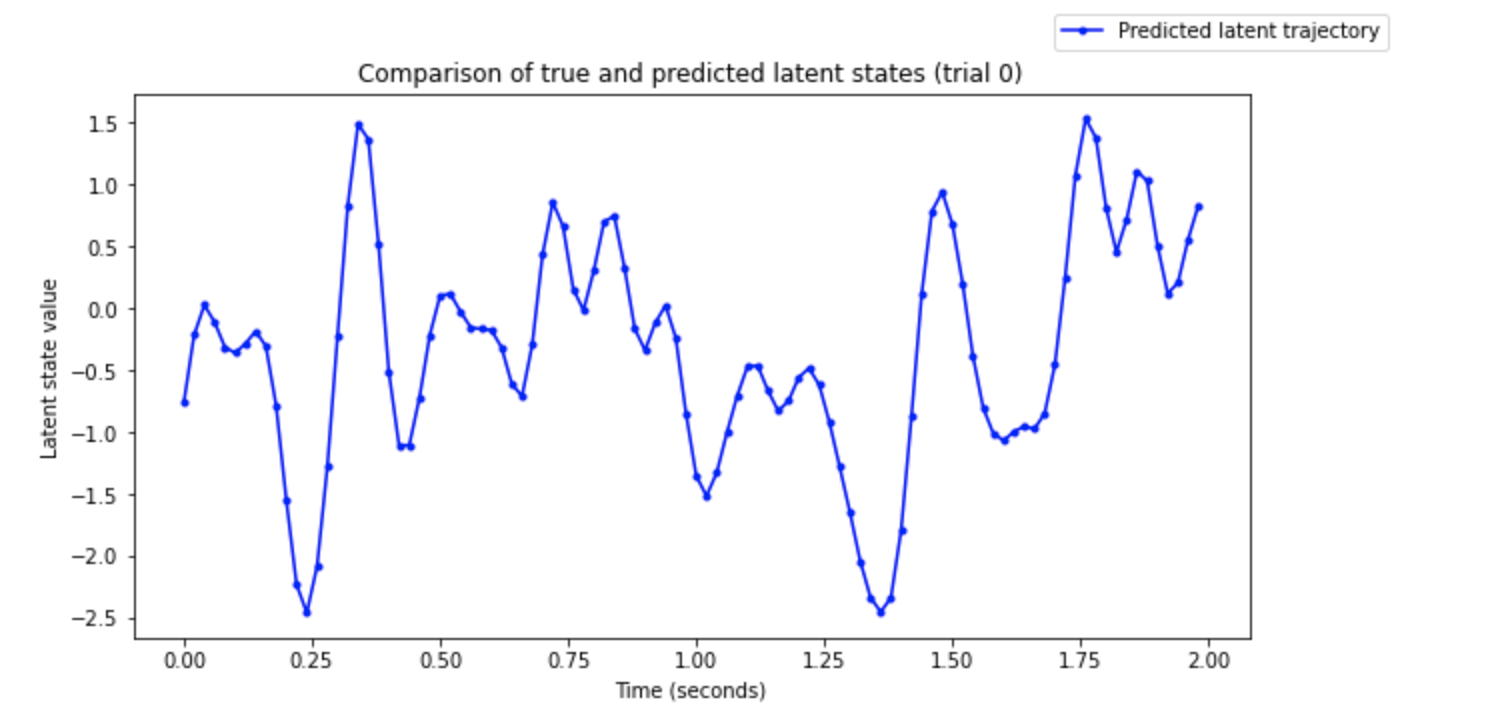

In [62]:
display(Image(data_dir / "example_predicted_traj.png"))

**TO-DO:** Compare the true and predicted latent trajectories. There should be one major difference. Could you have seen this coming after observing the one major difference between the true and predicted parameters in Section 1.4? Explain what's going on.

## Section 2: Investigating more complex simulated data

In this section, we'll dive into some more complex simulated data that was generated using 8 latent dimensions (instead of 1).  We'll look again at how predicted latent states compare to the true ones and at how to determine the dimensionality of the latent space.

### Section 2.1: Create higher-dimensional simulated data

Run the next cell to load a larger simulated dataset, generated a similar way to the data in Section 1 but with 8 latents.

In [ ]:
!gdown --id 1kvSuiklRT2jFVrTWXX_wMwO1Drrs61EU

with open("/content/section2_simulated_data.pickle", "rb") as file:
    spike_trains = pickle.load(file)
    latent_trajectories = pickle.load(file)
    true_C = pickle.load(file)

**TO-DO:** Use code to find the number of trials and number of neurons contained in the spiking data (`spike_trains`).  How many latent trajectories were used to create the data? The latent trajectories are stored in (`latent_trajectories`). The time bin size is 50ms. How many time bins were used for the latent trajectories? 

Remember that we use the same latent trajectories for every trial.

In [ ]:
n_trials = ...
n_neurons = ...
n_time_bins = ...
time_bin_size = 0.05
n_latents = ...
n_true_latent = n_latents

print(f"n_trials = {n_trials}")
print(f"n_neurons = {n_neurons}")
print(f"n_time_bins = {n_time_bins}")
print(f"n_latents = {n_latents}")

### Section 2.2: Fitting GPFA

Let's fit GPFA on this data! Unlike before, we will split the trials into train and test trials. We should do k-fold cross-validation but we want to save some time in this tutorial. This will take a couple minutes so please be patient.

In [ ]:
# Get info on train/test splits
n_train_trials = int(0.8 * n_trials)
n_test_trials = n_trials - n_train_trials
train_inds = np.arange(0, n_train_trials)
test_inds = np.arange(n_train_trials, n_trials)

# Set up bin size in format required by GPFA
bin_size = (time_bin_size * 1000) * pq.ms

# Initialize GPFA
n_latents = 8
gpfa = GPFA(bin_size=bin_size, x_dim=n_latents)

# Fit GPFA on training data
gpfa.fit(spike_trains[:n_train_trials])

**TO-DO:** Complete the following code to get the log likelihood of the fit for the training and testing data. We will divide by the number of training and testing trials so we can directly compare these values.

Hints: `spike_trains[n_train_trials:]` gives the test data. Use the `score` method: https://elephant.readthedocs.io/en/latest/reference/_toctree/gpfa/elephant.gpfa.gpfa.GPFA.html#elephant.gpfa.gpfa.GPFA.transform

In [ ]:
# TO-DO: compute log-likelihood on train data
LL_train = ...
print(f"Log likelihood of the training set: {LL_train / n_train_trials}")

# TO-DO: compute log-likelihood on test data
LL_test = ...
print(f"Log likelihood of the testing set: {LL_test / n_test_trials}")

### Section 2.3: Visualize GPFA trajectories

Next, let's plot the estimated latent trajectories  over time.

In the first row, each subplot shows the true latent trajectories for one latent dimension. 

In the second row, each subplot shows a single latent dimension extracted by GPFA for the first trial. 

In [ ]:
# Get predicted trajectories
outs = gpfa.transform(
    spike_trains, returned_data=["latent_variable", "latent_variable_orth"]
)
predicted_latent_trajectories = outs["latent_variable"]
predicted_latent_trajectories_orth = outs["latent_variable_orth"]

In [ ]:
fig, axes = plt.subplots(2, 8, figsize=(20, 5), sharex=True)
t_vec = np.arange(0, n_time_bins) * time_bin_size
i_trial = test_inds[0]
for i_latent in range(n_latents):
    axes[0][i_latent].plot(t_vec, latent_trajectories[i_trial][i_latent])
    axes[0][i_latent].set(title=f"True latent dim {i_latent}")
    axes[1][i_latent].plot(t_vec, predicted_latent_trajectories[i_trial][i_latent])
    axes[1][i_latent].set(title=f"Predicted latent dim {i_latent}", xlabel="Time (s)")

plt.tight_layout()

**TO-DO:** The predicted latents don't match the true latents. Did something go wrong or is this expected?

### Section 2.4: Compare model estimates to the ground-truth data

We need a way to compare predicted latent trajectories to true ones to determine if GPFA has extracted the correct underlying low dimensional structure. As you were asked to think about above, the predicted and true latent trajectories won't necessarily appear similar even if the model fitting went well. However, the space spanned by the predicted trajectories should be the same as the space spanned by the latent trajectories if the model extracted the overall latent space correctly.

To see whether this is true, we can do two different tests. As done in the paper, we can perform PCA on the predicted and true latent trajectories to see if the orthonormalized, variance-sorted dimensions match, which should happen if they span the same space. Or, more directly, we can just ask whether the true latent trajectories can be expressed as linear combinations of the predicted latent trajectories. Specifically, we can use linear regression to see if the true latent trajectory for a given dimension can be made out of linear combinations of the predicted latent trajectories.

 We'll take this second more direct approach first, then do PCA.

**TO-DO:** Complete the line that performs linear regression to combine the predicted latent trajectories to form each of the true latent trajectories (in `latent_trajectories`) on the first test trial. We'll look at the first 3 true latents. **Make sure the data is in the right format for sklearn LinearRegression.** For example the input should be number of samples by number of features.

In [ ]:
i_trial = test_inds[0]  # pick a test trial

# Fit linear regression
linear_reg = linear_model.LinearRegression()
linear_reg.fit(...)
linear_combos_of_predicted = linear_reg.predict(...)

# Visualize
t_vec = np.arange(0, n_time_bins) * time_bin_size
fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharex=True)
axes = axes.flatten()
for i_latent in range(8):
    axes[i_latent].plot(
        t_vec,
        predicted_latent_trajectories[i_trial].T,
        "b",
        label="Predicted latent trajectories",
    )
    axes[i_latent].plot(
        t_vec,
        latent_trajectories[i_trial][i_latent],
        "r",
        linewidth=2,
        label="Actual latent trajectory",
    )
    axes[i_latent].plot(
        t_vec,
        linear_combos_of_predicted[:, i_latent].T,
        "xk",
        label="Fitted linear combo of predicted trajectories",
    )
    axes[i_latent].set(title=f"True latent dim {i_latent}")

axes[i_latent].set(xlabel="Time (s)")
h, l = axes[0].get_legend_handles_labels()
h, l = h[i_latent:], l[i_latent:]
axes[i_latent + 1].axis("Off")
axes[i_latent + 1].legend(h, l);

We can loop over trials and compute the average R2 over trials for each latent prediction.

In [ ]:
from sklearn.metrics import r2_score

r2 = np.zeros((n_latents,))
for i_trial in test_inds:

    # Fit linear regression
    linear_reg = linear_model.LinearRegression()
    linear_reg.fit(
        predicted_latent_trajectories[i_trial].T, latent_trajectories[i_trial].T
    )
    linear_combos_of_predicted = linear_reg.predict(
        predicted_latent_trajectories[i_trial].T
    )

    r2 += r2_score(
        latent_trajectories[i_trial].T,
        linear_combos_of_predicted,
        multioutput="raw_values",
    )  # linear_reg.score(predicted_latent_trajectories[i_trial].T, latent_trajectories[i_trial].T)
r2 /= len(test_inds)
print(f"R^2 for each latent dimension, averaged across trials: {r2}")

**TO-DO:** Based on this, do the true and predicted latent trajectories seem to span the same 8-dimensional manifold or not? Explain why or why not.

### (Optional) Section 2.5: orthogonal latents

Now let's try the second method of looking at the orthonormalized trajectories. Let's first look at the orthonormalized predicted trajectories.

In [ ]:
# Plot predicted latents again
fig, axes = plt.subplots(1, 8, figsize=(20, 5), sharex=True, sharey=True)
t_vec = np.arange(0, n_time_bins) * time_bin_size
i_trial = train_inds[0]
for i_latent in range(n_latents):
    axes[i_latent].plot(t_vec, predicted_latent_trajectories[i_trial][i_latent])
    axes[i_latent].set(title=f"Predicted latent {i_latent}")
plt.tight_layout()

# Predict orthonormalized latents again
fig, axes = plt.subplots(1, 8, figsize=(20, 5), sharex=True, sharey=True)
t_vec = np.arange(0, n_time_bins) * time_bin_size
i_trial = train_inds[0]
for i_latent in range(n_latents):
    axes[i_latent].plot(t_vec, predicted_latent_trajectories_orth[i_trial][i_latent])
    axes[i_latent].set(
        title=f"Orthonormalized \n predicted latent {i_latent}", xlabel="Time (s)"
    )
plt.tight_layout()

**TO-DO**: How does the variance change across non-orthonormalized dimensions 1 through 8? How does it change across orthonormalized dimensions 1 through 8? Do you think the fitted model's non-orthonormalized dimension 1 would resemble the ground truth non-orthonormalized dimension 1? Do you think the fitted model's orthonormalized dimension 1 would resemble the ground truth orthonormalized dimension 1? Why or why not?

Let's now get the orthonormalized ground truth dimensions and compare with the orthonormalized predicted dimensions.

In [ ]:
i_trial = test_inds[0]

# Orthogonalize the true latents
latent_trajectories_orth, _, _ = gpfa_util.orthonormalize(
    latent_trajectories[i_trial], true_C
)

# Visualize
fig, axes = plt.subplots(2, 4, figsize=(10, 5), sharey=True)
axes = axes.flatten()

for i_latent in range(n_latents):
    axes[i_latent].plot(latent_trajectories_orth[i_latent], "x")
    sq_errs = np.sum(
        (
            latent_trajectories_orth[i_latent]
            - predicted_latent_trajectories_orth[i_trial][i_latent]
        )
        ** 2
    )
    flipped_sq_errs = np.sum(
        (
            -latent_trajectories_orth[i_latent]
            - predicted_latent_trajectories_orth[i_trial][i_latent]
        )
        ** 2
    )

    dim_sign = 1
    if np.sum(flipped_sq_errs) < np.sum(sq_errs):
        dim_sign = -1
    axes[i_latent].plot(
        dim_sign * predicted_latent_trajectories_orth[i_trial][i_latent], "k"
    )
    axes[i_latent].set(title=f"Orthonormalized latent {i_latent}")
axes[0].legend(["Ground truth", "Model prediction"])

plt.tight_layout()

Note the match isn't that close as we're in a low-data regime. With more training data, these would resemble each other more.

**TO-DO (optional, because it's a hard question):** In general, we find a good match between the n'th principal component of the true latent space and the n'th principal component of the predicted latent space. However, the match isn't perfect, with some trajectories appearing quite off. What might be causing these discrepancies, despite the very high R^2 values we got in the linear regression test above? (Hint: "amount of variance" or "rotation" might be useful phrases to use in an answer.)

### Section 2.6: Recover the dimensionality of the underlying latent space

Finally, let's forget we simulated this data and estimate the dimensionality of the underlying space from the spike data.

We want to fit GPFA models with different assumed latent dimensionality and compare the log-likelihood. This code loops over different latent dimensions and fits GPFA models of each dimension. It'll take a couple minutes to run. `gpfas` is a dictionary where the keys are the number of latents and the values are the fitted GPFA models.

In [ ]:
n_latents_to_try = [2, 5, 8, 12, 15]
gpfas = {}
for n_latents in n_latents_to_try:
    gpfas[n_latents] = GPFA(x_dim=n_latents)
    gpfas[n_latents].fit(spike_trains[:n_train_trials])

#### Section 2.6.1: Test log-likelihood

Let's first look at the log-likelihood of each GPFA model

In [ ]:
# Gather log-likelihoods of the GPFA models
log_likelihoods = []
for n_latents in n_latents_to_try:
    test_LL = gpfas[n_latents].score(spike_trains[n_train_trials:])
    log_likelihoods.append(test_LL)

# Visualize
fig, ax = plt.subplots(1, 1)
ax.plot(n_latents_to_try, log_likelihoods, "-o")
ax.set(xlabel="Latent state dimensionality", ylabel="Test log likelihood");

In [ ]:
print(log_likelihoods)

#### Section 2.6.2: Test leave-neuron-out prediction error

Now we'll use leave-neuron-out prediction error as in [1]. We will leave one neuron out at a time, compute the latent trajectories, and predict that neuron's activity. The prediction error is then the summed squared difference between the true (square-rooted binned) neural responses and the predicted responses on the test data.

In the following cell, we define the helper function `compute_leave_out_neuron_validation` which performs this computation. 

We can also predict the neural response just using the first `n` orthogonal trajectories of a model with higher than n latent space dimensionality. This is the reduced GPFA model from [1]. 

In [ ]:
# @markdown Execute to get helper function `compute_leave_out_neuron_validation`
def compute_leave_out_neuron_validation(
    gpfa_model, test_spike_trains, n_orth_latents=None
):

    n_neurons = gpfa_model.params_estimated["C"].shape[0]
    n_latents = gpfa_model.params_estimated["C"].shape[1]
    n_test_trials = len(test_spike_trains)

    if n_orth_latents is None:
        n_orth_latents = [n_latents]

    # Get y_test for all neurons
    bin_size = gpfa_model.bin_size
    seqs_temp = gpfa_util.get_seqs(test_spike_trains, bin_size)

    # Set up storage
    errors = {}
    predictions = {}
    predictions["y_test"] = seqs_temp["y"]
    for n_orth_latent in n_orth_latents:
        errors[f"{n_orth_latent}outof{n_latents}latents"] = 0
        predictions[f"y_test_predictions_{n_orth_latent}outof{n_latents}latents"] = [
            None
        ] * n_test_trials
        for i_trial in range(n_test_trials):
            predictions[f"y_test_predictions_{n_orth_latent}outof{n_latents}latents"][
                i_trial
            ] = np.zeros_like(predictions["y_test"][i_trial])

    for leave_out_neuron in range(n_neurons):

        # Get indices leaving out this neuron
        leave_out_indices = [i for i in range(n_neurons) if i != leave_out_neuron]

        # Remove neuron from spike trains
        altered_spike_trains = copy.deepcopy(test_spike_trains)
        for i_trial in range(n_test_trials):
            altered_spike_trains[i_trial] = [
                test_spike_trains[i_trial][i]
                for i in range(n_neurons)
                if i != leave_out_neuron
            ]

        # Alter GPFA C/d/R parameters to remove neuron
        altered_gpfa = copy.deepcopy(gpfa_model)
        altered_gpfa.params_estimated["C"] = altered_gpfa.params_estimated["C"][
            leave_out_indices
        ]
        altered_gpfa.params_estimated["d"] = altered_gpfa.params_estimated["d"][
            leave_out_indices
        ]
        altered_gpfa.params_estimated["R"] = altered_gpfa.params_estimated["R"][
            leave_out_indices
        ]
        altered_gpfa.params_estimated["R"] = altered_gpfa.params_estimated["R"][
            :, leave_out_indices
        ]
        altered_gpfa.has_spikes_bool = altered_gpfa.has_spikes_bool[leave_out_indices]

        # Find latent trajectories without that neuron
        # this is based on gpfa.transform, the only reason we can't use that is we want the full matrix C to orthogonalize
        seqs = gpfa_util.get_seqs(altered_spike_trains, altered_gpfa.bin_size)

        # for seq in seqs:
        #     seq['y'] = seq['y'][altered_gpfa.has_spikes_bool, :]

        seqs, ll = gpfa_core.exact_inference_with_ll(
            seqs, altered_gpfa.params_estimated, get_ll=True
        )
        Corth, seqs = gpfa_core.orthonormalize(gpfa_model.params_estimated, seqs)

        outs = {x: seqs[x] for x in ["y", "latent_variable", "latent_variable_orth"]}

        for n_orth_latent in n_orth_latents:
            for i_trial in range(n_test_trials):
                pred = (
                    Corth[leave_out_neuron, : (n_orth_latent + 1)]
                    @ outs["latent_variable_orth"][i_trial][: (n_orth_latent + 1)]
                    + gpfa_model.params_estimated["d"][leave_out_neuron]
                )
                predictions[
                    f"y_test_predictions_{n_orth_latent}outof{n_latents}latents"
                ][i_trial][leave_out_neuron] = pred

    # Compute errors
    for n_orth_latent in n_orth_latents:
        for i_trial in range(n_test_trials):
            errors[f"{n_orth_latent}outof{n_latents}latents"] += np.sum(
                (
                    predictions[
                        f"y_test_predictions_{n_orth_latent}outof{n_latents}latents"
                    ][i_trial]
                    - predictions[f"y_test"][i_trial]
                )
                ** 2
            )
    return errors, predictions

In [ ]:
# Run leave-neuron-out for reduced GPFA model
errors, predictions = compute_leave_out_neuron_validation(
    gpfas[n_latents_to_try[-1]], spike_trains[n_train_trials:], n_latents_to_try
)

# Run leave-neuron-out for different dim GPFA models
for n_latents in n_latents_to_try:
    these_errors, these_predictions = compute_leave_out_neuron_validation(
        gpfas[n_latents], spike_trains[n_train_trials:]
    )
    errors = {**errors, **these_errors}
    predictions = {**predictions, **these_predictions}

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.plot(
    n_latents_to_try, [errors[f"{i}outof{i}latents"] for i in n_latents_to_try], "-ok"
)
ax.plot(
    n_latents_to_try,
    [errors[f"{i}outof{n_latents_to_try[-1]}latents"] for i in n_latents_to_try],
    "-og",
)
ax.legend(["GPFA", "Reduced GPFA"])
ax.set(xlabel="Latent state dimensionality", ylabel="Prediction error");

In [ ]:
[errors[f"{i}outof{i}latents"] for i in n_latents_to_try]

**TO-DO:** What underlying dimensionality would you assume the neural data has based on these plots? 

Do the log-likelihood and prediction errors give similar results? Why might you use one over the other? 

## Section 3: Investigating real neural data 

We will now attempt to apply GPFA to actual neural data.

*Note that you have to do very minimal coding in this section, instead you'll mainly be inspecting output of different analysis.*

The dataset we will be using is from [3] so please check there for more details about the experiment.

The monkey reached in 8 directions to the angles (30 π, 70 π, 110 π, 150 π, 190 π, 230 π, 310 π, 350 π) while motor cortical neural data was recorded. We have 182 trials for each of the 8 reaching angles. For each trial, we have the monkey's arm trajectory over time and the neural data from 98 neurons. The neural data includes both well-isolated single-neuron units (~30% of all units), as well as multi-neuron units.  On each trial, both the neural data and arm trajectory are taken from 300 ms before movement onset until 100 ms after movement end.

### Section 3.1: Load & visualize neural data 

We load in the data below. `data` is a numpy array of shape trials x reaches (182 x 8). Each entry has a tuple of the data for that number trial and that reach direction. The first element of the tuple is the trial id. The second element is a spikes matrix, of shape neurons by time bins (97 by varies). Each time bin is 1ms, a zero entry indicates that the unit did not spike in that bin, whereas a one indicates that it did spike one. 

In [ ]:
!gdown --id 1plgmaQkY58oC9bS7uaV1cLHCTxT6Elle

data_all = sio.loadmat("/content/dec_G20040508.mat")

data = data_all["trial"]

n_reaches = 8
n_trials = 182
n_neurons = 97
movement_onset = 0.3  # s after data starts
movement_offset = 0.1  # s before data ends

# Set up bin size in format required by GPFA
time_bin_size = 0.02
bin_size = (time_bin_size * 1000) * pq.ms

Let's process the spikes into the form required by GPFA.

In [ ]:
# Process data by reach

spike_trains = np.empty(shape=(n_reaches, n_trials), dtype=object)

for i_reach in range(n_reaches):

    for i_trial in range(n_trials):

        spike_trains[i_reach, i_trial] = [None] * n_neurons

        spikes = data[i_trial, i_reach][1]

        for i_neuron in range(n_neurons):

            spike_trains[i_reach, i_trial][i_neuron] = (
                np.where(spikes[i_neuron])[0] / 1000
            )

            # Get length of trial
            t_stop = spikes.shape[1] / 1000

            # Round up to nearest bin
            t_stop = (t_stop // time_bin_size + 1) * time_bin_size

            # Convert to special format
            spike_trains[i_reach, i_trial][i_neuron] = neo.SpikeTrain(
                spike_trains[i_reach][i_trial][i_neuron], units="sec", t_stop=t_stop
            )

### Section 3.2: Fitting GPFA

Let's fit one GPFA model for all reach directions. In [1], they fit a different GPFA model for each reach but we'll fit on all reaches so we can examine low-d tractories for different reach directions. 

We will use the first 145 trials of each reach for training data and the last 37 for testing data.

Fitting this model is very time-consuming so we have done it for you and you can load it in. We used this code:

```
np.random.seed(2)

n_train_trials = 145
n_test_trials = n_trials - n_train_trials

# Initialize GPFA
n_latents = 15
gpfa = GPFA(bin_size=bin_size, x_dim=n_latents)

# Fit GPFA
gpfa.fit(spike_trains[:, :n_train_trials].reshape((-1,)))

# Save file
with open('neural_data_15_latents.pickle', 'wb') as handle:
    pickle.dump(gpfa, handle, protocol=pickle.HIGHEST_PROTOCOL)
```

In [ ]:
!gdown --id 1yHT42ncPDwa8zqUrlZGrY-VHLBhrsvUJ

n_train_trials = 145
n_test_trials = n_trials - n_train_trials
n_latents = 15

with open("/content/neural_data_15_latents.pickle", "rb") as handle:
    gpfa = pickle.load(handle)

Let's get the trajectories (both orthogonal and standard) and square rooted binned neural data for the training and test trials.


In [ ]:
outs = gpfa.transform(
    spike_trains[:, :n_train_trials].reshape((-1,)),
    returned_data=["latent_variable", "latent_variable_orth", "y"],
)

latent_trajectories_train, latent_trajectories_orth_train, sqrt_spike_counts_train = (
    outs["latent_variable"].reshape((n_reaches, n_train_trials)),
    outs["latent_variable_orth"].reshape((n_reaches, n_train_trials)),
    outs["y"].reshape((n_reaches, n_train_trials)),
)

outs = gpfa.transform(
    spike_trains[:, n_train_trials:].reshape((-1,)),
    returned_data=["latent_variable", "latent_variable_orth", "y"],
)

latent_trajectories_test, latent_trajectories_orth_test, sqrt_spike_counts_test = (
    outs["latent_variable"].reshape((n_reaches, n_test_trials)),
    outs["latent_variable_orth"].reshape((n_reaches, n_test_trials)),
    outs["y"].reshape((n_reaches, n_test_trials)),
)

### Section 3.3: Plot individual trials of a given reach direction, aligned to behavioral events

Execute the next cell to visualize the latent trajectories. Specifically, it'll show 10 trials for each latent dimension. You can choose the reach direction to display, whether to align to movement onset or offset, and whether to use the standard latents or the orthogonalized latents. The blue dots show the time of movement onset, the green dots show the time of movement offset.

If you want to be able to make each plot outside of the interactive context for easier comparison, you can run the following command:

```
plot_aligned_latents(i_reach, alignment, latent_type, latent_trajectories_test, 
                    latent_trajectories_orth_test, n_latents, movement_onset, 
                    movement_offset, time_bin_size)
                    ```

Just change `i_reach` to the reach number, `alignment` to either `onset` or `offset`, and `latent_type` to either `standard` or `orthogonal`.

In [ ]:
# @markdown Execute to visualize aligned latents


def plot_aligned_latents(
    i_reach,
    alignment,
    latent_type,
    latent_trajectories,
    latent_trajectories_orth,
    n_latents,
    movement_onset,
    movement_offset,
    time_bin_size,
):

    assert latent_type in ["orthogonal", "standard"]
    assert alignment in ["offset", "onset"]

    n_rows = 3
    n_cols = int(np.ceil(n_latents / 3))

    latents = (
        latent_trajectories_orth[i_reach]
        if latent_type == "orthogonal"
        else latent_trajectories[i_reach]
    )

    onset_bin = int(movement_onset / time_bin_size)
    offset_bin = int(movement_offset / time_bin_size)
    min_time_bin = np.min([latents[i_trial].shape[1] for i_trial in range(10)])
    max_time_bin = np.max([latents[i_trial].shape[1] for i_trial in range(10)])

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 10), sharey=True, sharex=True)
    axes = axes.flatten()

    if alignment == "onset":
        t_vec = time_bin_size * np.arange(max_time_bin)
    else:
        t_vec = time_bin_size * np.arange(-min_time_bin + offset_bin, offset_bin)

    for i_latent in range(n_latents):
        for i_trial in range(10):

            if alignment == "onset":
                this_t_vec = t_vec[: len(latents[i_trial][i_latent])]
                axes[i_latent].plot(
                    this_t_vec, latents[i_trial][i_latent], "k", alpha=0.2
                )
                aligned_onset_bin = onset_bin
            else:
                this_t_vec = t_vec
                n_time_bins_drop = latents[i_trial].shape[1] - min_time_bin
                aligned_onset_bin = onset_bin - n_time_bins_drop
                axes[i_latent].plot(
                    t_vec, latents[i_trial][i_latent, n_time_bins_drop:], "k", alpha=0.2
                )

            axes[i_latent].scatter(
                this_t_vec[aligned_onset_bin],
                latents[i_trial][i_latent, onset_bin],
                c="b",
            )
            axes[i_latent].scatter(
                this_t_vec[-offset_bin], latents[i_trial][i_latent, -offset_bin], c="g"
            )
            axes[i_latent].set(title=f"Latent dim {i_latent}")

    axes[np.round((n_rows - 1) * n_cols + 0.5 * n_cols).astype("int")].set(
        xlabel="Time (s)"
    )
    axes[
        np.round((n_rows - 1) * n_cols + 0.5 * n_cols).astype("int")
    ].xaxis.get_label().set_fontsize(20)

    fig.suptitle(
        f"{latent_type} latent trajectories on test data aligned to movement {alignment}",
        fontsize=20,
    )


@widgets.interact(
    i_reach=widgets.IntSlider(value=0, min=0, max=7, description="Reach Number"),
    alignment=widgets.Dropdown(
        options=[("Movement onset", "onset"), ("Movement offset", "offset")],
        value="onset",
        description="Alignment",
    ),
    latent_type=widgets.Dropdown(
        options=["orthogonal", "standard"],
        value="orthogonal",
        description="Latent type",
    ),
)
def interactive_plot(i_reach, alignment, latent_type):
    plot_aligned_latents(
        i_reach,
        alignment,
        latent_type,
        latent_trajectories_test,
        latent_trajectories_orth_test,
        n_latents,
        movement_onset,
        movement_offset,
        time_bin_size,
    )

### Section 3.4: Plot 3 latent trajectories vs each other

Let's plot the first 3 orthogonal latents vs each other. We'll first do this for the first reach alone, with blue and green dots denoting movement onset and offset.

In [ ]:
# @markdown Execute to visualize trajectories of single reach direction
from matplotlib import animation

onset_bin = int(movement_onset / time_bin_size)
offset_bin = int(movement_offset / time_bin_size)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection="3d")

lines = {}
onset_points = {}
offset_points = {}
for i_trial in range(10):
    (lines[i_trial],) = ax.plot([], [], [], "k", alpha=0.2)
    (onset_points[i_trial],) = ax.plot([], [], [], "ob")
    (offset_points[i_trial],) = ax.plot([], [], [], "og")
ax.set(
    xlim=[-2, 2],
    ylim=[-2, 2],
    zlim=[-2, 2],
    xlabel="Latent dim 1",
    ylabel="Latent dim 2",
    zlabel="Latent dim 3",
)

latents = latent_trajectories_orth_test[i_reach]


def drawframe(n):
    for i_trial in range(10):
        lines[i_trial].set_data(latents[i_trial][0, :n], latents[i_trial][1, :n])
        lines[i_trial].set_3d_properties(latents[i_trial][2, :n])
        if n >= onset_bin:
            onset_points[i_trial].set_data(
                [latents[i_trial][0, onset_bin]], [latents[i_trial][1, onset_bin]]
            )
            onset_points[i_trial].set_3d_properties([latents[i_trial][2, onset_bin]])
        if n >= (latents[i_trial].shape[1] - offset_bin):
            offset_points[i_trial].set_data(
                [latents[i_trial][0, -offset_bin]], [latents[i_trial][1, -offset_bin]]
            )
            offset_points[i_trial].set_3d_properties([latents[i_trial][2, -offset_bin]])

    return (lines[0],)


ax.view_init(elev=30, azim=150)

anim = animation.FuncAnimation(fig, drawframe, frames=50, interval=100, blit=True)

plt.close()
anim

Next, we'll visualize all the reach directions at once. Each thick line shows the mean trajectory for one reach direction, while the fainter lines represent individual trial trajectories.

You can use the helper function `plot_all_reach_trajectories(latent_trajectories_orth, n_indiv_trials_to_plot=5, animate=True, elev_amount=60, view_angle=-60)` to visualize this in different ways. If you want a static plot instead of an animation, change animate to False. You can also change `elev_amount` and `view_angle` to change the view of the 3d plot shown.

In [ ]:
# @markdown Execute to get helper function `plot_all_reach_trajectories`


def plot_all_reach_trajectories(
    trajectories,
    n_indiv_trials_to_plot,
    animate=True,
    elev_amount=60,
    view_angle=-60,
    n_reaches=n_reaches,
    n_test_trials=n_test_trials,
    movement_onset=movement_onset,
    movement_offset=movement_offset,
    time_bin_size=time_bin_size,
):
    reaches = [30, 70, 110, 150, 190, 230, 310, 350]

    # Get mean latent trajectories for each reach direction
    min_time_bins = np.min(
        [
            trajectories.reshape((-1,))[i_trial].shape[1]
            for i_trial in range(n_reaches * n_test_trials)
        ]
    )

    mean_trajectories = np.zeros((n_reaches, 3, min_time_bins))
    for i_reach in range(n_reaches):
        for i_trial in range(0, n_test_trials):
            mean_trajectories[i_reach] += trajectories[i_reach, i_trial][
                :3, :min_time_bins
            ]
    mean_trajectories /= n_test_trials

    onset_bin = int(movement_onset / time_bin_size)
    offset_bin = int(movement_offset / time_bin_size)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1, projection="3d")
    c_vec = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    lines = {}
    indiv_trial = {}
    onset_points = {}
    for i_reach in range(8):
        for i_trial in range(0, n_indiv_trials_to_plot):
            (indiv_trial[(i_reach, i_trial)],) = ax.plot(
                [], [], [], linewidth=1, color=c_vec[i_reach], alpha=0.4
            )

        (lines[i_reach],) = ax.plot(
            [],
            [],
            [],
            linewidth=2,
            color=c_vec[i_reach],
            label=f"{reaches[i_reach]} degrees reach",
        )
        (onset_points[i_reach],) = ax.plot([], [], [], "ob")
    ax.set(
        xlim=[-2, 2],
        ylim=[-2, 2],
        zlim=[-2, 2],
        xlabel="Latent dim 1",
        ylabel="Latent dim 2",
        zlabel="Latent dim 3",
    )
    plt.legend()

    def drawframe(n):
        for i_reach in range(8):
            for i_trial in range(0, n_indiv_trials_to_plot):
                indiv_trial[(i_reach, i_trial)].set_data(
                    trajectories[i_reach, i_trial][0, :n],
                    trajectories[i_reach, i_trial][1, :n],
                )
                indiv_trial[(i_reach, i_trial)].set_3d_properties(
                    trajectories[i_reach, i_trial][2, :n]
                )

            lines[i_reach].set_data(
                mean_trajectories[i_reach][0, :n], mean_trajectories[i_reach][1, :n]
            )
            lines[i_reach].set_3d_properties(mean_trajectories[i_reach][2, :n])
            if n >= onset_bin:
                onset_points[i_reach].set_data(
                    [mean_trajectories[i_reach][0, onset_bin]],
                    [mean_trajectories[i_reach][1, onset_bin]],
                )
                onset_points[i_reach].set_3d_properties(
                    [mean_trajectories[i_reach][2, onset_bin]]
                )

        return (lines[0],)

    ax.view_init(elev=elev_amount, azim=view_angle)

    if animate:
        anim = animation.FuncAnimation(
            fig, drawframe, frames=50, interval=100, blit=True
        )
        plt.close()
        return anim

    else:
        drawframe(60)

In [ ]:
anim = plot_all_reach_trajectories(
    latent_trajectories_orth_test,
    n_indiv_trials_to_plot=5,
    animate=True,
    elev_amount=30,
    view_angle=150,
)
anim

**TO-DO:** Do you find this visualization technique helpful for getting a handle on what the latent trajectories look like? 

Describe what you see - what happens over time and how does it vary by reach? Does it seem like the neural trajectories are different for different reaches? If so, are they well separated? That is, would you be able to tell what the reach direction was just from observing a single trial trajectory? 

Does the relationship of the mean neural trajectories relate to the relationship of the reach directions?


## Section 4: Comparing GPFA, PCA & FA on real neural data

Yu et al. argue that GPFA is superior to existing two-stage methods for dimensionality reduction and visualization of neuronal population dynamics, where data are first smoothed and then transformed using a method that is insensitive to time-dependence in the data. To see this point, perform PCA and FA on the data so we can compare it to the GPFA results.

### Section 4.1: Perform Principal Components Analysis (PCA) and Factor Analysis (FA) on the data

Yu et al. argue that GPFA is superior to existing two-stage methods for dimensionality reduction and visualization of neuronal population dynamics, where data are first smoothed and then transformed using a method that is insensitive to time-dependence in the data, such as PCA or FA. 

Let's do the first step of smoothing the data first. We have already returned the binned and square-rooted spike counts from the transform method. As in [1], we will smooth the binned square-rooted spike times over time using a Gaussian filter.  

 

In [ ]:
smoothed_spikes_train = np.zeros_like(sqrt_spike_counts_train)
smoothed_spikes_test = np.zeros_like(sqrt_spike_counts_test)
smooth_sigma = 0.02 / time_bin_size  # 20 ms to bins

for i_reach in range(n_reaches):
    for i_trial in range(n_train_trials):
        smoothed_spikes_train[i_reach, i_trial] = scipy.ndimage.gaussian_filter1d(
            sqrt_spike_counts_train[i_reach, i_trial], smooth_sigma, axis=1
        )
    for i_trial in range(n_test_trials):
        smoothed_spikes_test[i_reach, i_trial] = scipy.ndimage.gaussian_filter1d(
            sqrt_spike_counts_test[i_reach, i_trial], smooth_sigma, axis=1
        )

# Visualize for first trial
i_trial = 0
i_reach = 0
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

axes[0].pcolormesh(sqrt_spike_counts_train[i_reach, i_trial], cmap="gray_r")
axes[1].pcolormesh(smoothed_spikes_train[i_reach, i_trial], cmap="gray_r")

axes[0].set(
    title="Binned & square-rooted spike counts",
    ylabel="Neuron",
    xlabel="Time (s)",
    xticks=np.arange(0, sqrt_spike_counts_train[i_reach, i_trial].shape[1], 5),
    xticklabels=np.arange(0, sqrt_spike_counts_train[i_reach, i_trial].shape[1], 5)
    * time_bin_size,
)

axes[1].set(
    title="Smoothed with Gaussian filter",
    ylabel="Neuron",
    xlabel="Time (s)",
    xticks=np.arange(0, sqrt_spike_counts_train[i_reach, i_trial].shape[1], 5),
    xticklabels=np.arange(0, sqrt_spike_counts_train[i_reach, i_trial].shape[1], 5)
    * time_bin_size,
);

**TO-DO:** Perform PCA and FA on the smoothed train spike data. Transform the test data and save the matrices as pc_transform and fa_transform. 

We want to perform dimensionality reduction over the neurons so each neuron is a feature. Each sample is a different data point - we can now combine over trials because the temporal structure no longer matters. We first transform the data to be what sklearn PCA & FA expect: an array of `n_samples` by `n_features`

In [ ]:
# Transform data to correct format
input_data_train = []
trial_ids_train = []
input_data_test = []
trial_ids_test = []
for i_reach in range(n_reaches):
    for i_trial in range(n_train_trials):
        input_data_train.append(smoothed_spikes_train[i_reach, i_trial].T)
        trial_ids_train.append(
            i_trial * np.ones(smoothed_spikes_train[i_reach, i_trial].T.shape[0])
        )

    for i_trial in range(n_test_trials):
        input_data_test.append(smoothed_spikes_test[i_reach, i_trial].T)
        trial_ids_test.append(
            i_trial * np.ones(smoothed_spikes_test[i_reach, i_trial].T.shape[0])
        )

input_data_train = np.concatenate(input_data_train)
input_data_test = np.concatenate(input_data_test)
trial_ids_train = np.concatenate(trial_ids_train)
trial_ids_test = np.concatenate(trial_ids_test)


# TO-DO: Fit PCA & FA models
pca = PCA(...)  # your code here
# your code to fit pca here
pc_transform = ...  # your code here

fa = FactorAnalysis(...)  # your code here
# your code to fit pca here
fa_transform = ...  # your code here


# Transform back to original format so we can plot by trial
pca_trajectories_test = np.zeros_like(latent_trajectories_orth_test)
fa_trajectories_test = np.zeros_like(latent_trajectories_orth_test)

current_ind = 0
for i_reach in range(n_reaches):
    for i_trial in range(n_test_trials):
        trial_len = latent_trajectories_orth_test[i_reach, i_trial].shape[1]

        pca_trajectories_test[i_reach, i_trial] = pc_transform[
            current_ind : current_ind + trial_len
        ].T
        fa_trajectories_test[i_reach, i_trial] = fa_transform[
            current_ind : current_ind + trial_len
        ].T

        current_ind += trial_len

In [ ]:
anim = plot_all_reach_trajectories(
    pca_trajectories_test,
    n_indiv_trials_to_plot=5,
    animate=True,
    elev_amount=30,
    view_angle=150,
)
anim

In [ ]:
anim = plot_all_reach_trajectories(
    fa_trajectories_test,
    n_indiv_trials_to_plot=5,
    animate=True,
    elev_amount=30,
    view_angle=150,
)
anim

**TO-DO:** Compare the GPFA trajectories to the PCA and FA plots. What's the major visual difference (look at the individual trials, not the trial average)? What difference in the structure of the models explains the visual difference?

### Section 4.2: Cross-validated prediction errors vs. dimensionality for GPFA, PCA and FA

One important neuroscientific question we can ask is what is the dimensionality of activity in primary motor cortex? As above, we turn to leave-neuron-out prediction error for the answer. We have precomputed GPFA results for x_dim = [2, 5, 8, 12, 15, 18, 21, 24, 27, 30]. Here, you will compare the performance of these models to PCA and FA (Figure 5a from [1]).

First, we need these prediction errors for GPFA. Fitting these models and computing the prediction error takes an extremely long time so we've done it for you, using this code:

```
n_latents_to_try = [2, 5, 8, 12, 15, 18, 21, 24, 27, 30]
gpfas = {}
for n_latents in n_latents_to_try:
    gpfas[n_latents] = GPFA(x_dim=n_latents)
    # Fit GPFA
    gpfas[n_latents].fit(spike_trains[:, :n_train_trials].reshape((-1,)))

# Run leave-neuron-out for reduced GPFA model
errors, predictions = compute_leave_out_neuron_validation(gpfas[n_latents_to_try[-1]], spike_trains[:, n_train_trials:].reshape((-1,)), n_latents_to_try)

# Run leave-neuron-out for different dim GPFA models
for n_latents in [15, 18, 21, 24, 27, 30]:
    these_errors, these_predictions = compute_leave_out_neuron_validation(gpfas[n_latents], spike_trains[:, n_train_trials:].reshape((-1,)))
    errors = {**errors, **these_errors}
    predictions = {**predictions, **these_predictions}

with open('real_data_latent_search.pickle', 'wb') as handle:
    pickle.dump(gpfas, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('real_data_errors.pickle', 'wb') as handle:
    pickle.dump(errors, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('real_data_predictions.pickle', 'wb') as handle:
    pickle.dump(predictions, handle, protocol=pickle.HIGHEST_PROTOCOL)

```
You can just download the error file below.

In [ ]:
!gdown --id 1D31pn2DcJmQro29n35XZuFITjB5wp-IW

n_latents_to_try = [2, 5, 8, 12, 15, 18, 21, 24, 27, 30]

with open("/content/real_data_errors.pickle", "rb") as handle:
    errors_GPFA = pickle.load(handle)

Now we'll move on to PCA and FA. We first need to fit these models for all the latent state dimensionalities. We'll use helper functions `smooth_and_compute_PCA` and `smooth_and_compute_FA` (these combine above code into a function so we can easily change the sigma and number of latents).


Then, we'll compute the leave-neuron-out validation for PCA and factor analysis on the test data, using the helper functions `compute_leave_out_neuron_validation_PCA` and `compute_leave_out_neuron_validation_FA` 

In [ ]:
# @markdown Execute to enable helper functions `smooth_and_compute_PCA` and `smooth_and_compute_FA`
def smooth_and_compute_PCA(
    sqrt_spike_counts_train, sqrt_spike_counts_test, sigma_in_seconds, n_latents
):

    # Smooth spike trains
    smoothed_spikes_train = np.zeros_like(sqrt_spike_counts_train)
    smoothed_spikes_test = np.zeros_like(sqrt_spike_counts_test)
    smooth_sigma = sigma_in_seconds / time_bin_size  # 20 ms to bins

    for i_reach in range(n_reaches):
        for i_trial in range(n_train_trials):
            smoothed_spikes_train[i_reach, i_trial] = scipy.ndimage.gaussian_filter1d(
                sqrt_spike_counts_train[i_reach, i_trial], smooth_sigma, axis=1
            )
        for i_trial in range(n_test_trials):
            smoothed_spikes_test[i_reach, i_trial] = scipy.ndimage.gaussian_filter1d(
                sqrt_spike_counts_test[i_reach, i_trial], smooth_sigma, axis=1
            )

    # Transform data to correct format
    input_data_train = []
    trial_ids_train = []
    input_data_test = []
    trial_ids_test = []
    for i_reach in range(n_reaches):
        for i_trial in range(n_train_trials):
            input_data_train.append(smoothed_spikes_train[i_reach, i_trial].T)
            trial_ids_train.append(
                i_trial * np.ones(smoothed_spikes_train[i_reach, i_trial].T.shape[0])
            )

        for i_trial in range(n_test_trials):
            input_data_test.append(smoothed_spikes_test[i_reach, i_trial].T)
            trial_ids_test.append(
                i_trial * np.ones(smoothed_spikes_test[i_reach, i_trial].T.shape[0])
            )

    input_data_train = np.concatenate(input_data_train)
    input_data_test = np.concatenate(input_data_test)
    trial_ids_train = np.concatenate(trial_ids_train)
    trial_ids_test = np.concatenate(trial_ids_test)

    # Fit PCA & FA models
    pca = PCA(n_components=n_latents)
    pca.fit(input_data_train)
    pc_transform = pca.transform(input_data_test)

    # Transform back to original format so we can plot by trial
    pca_trajectories_test = np.zeros_like(latent_trajectories_orth_test)

    current_ind = 0
    for i_reach in range(n_reaches):
        for i_trial in range(n_test_trials):
            trial_len = latent_trajectories_orth_test[i_reach, i_trial].shape[1]

            pca_trajectories_test[i_reach, i_trial] = pc_transform[
                current_ind : current_ind + trial_len
            ].T

            current_ind += trial_len

    return pca, pca_trajectories_test, smoothed_spikes_train, smoothed_spikes_test


def smooth_and_compute_FA(
    sqrt_spike_counts_train, sqrt_spike_counts_test, sigma_in_seconds, n_latents
):

    # Smooth spike trains
    smoothed_spikes_train = np.zeros_like(sqrt_spike_counts_train)
    smoothed_spikes_test = np.zeros_like(sqrt_spike_counts_test)
    smooth_sigma = sigma_in_seconds / time_bin_size  # 20 ms to bins

    for i_reach in range(n_reaches):
        for i_trial in range(n_train_trials):
            smoothed_spikes_train[i_reach, i_trial] = scipy.ndimage.gaussian_filter1d(
                sqrt_spike_counts_train[i_reach, i_trial], smooth_sigma, axis=1
            )
        for i_trial in range(n_test_trials):
            smoothed_spikes_test[i_reach, i_trial] = scipy.ndimage.gaussian_filter1d(
                sqrt_spike_counts_test[i_reach, i_trial], smooth_sigma, axis=1
            )

    # Transform data to correct format
    input_data_train = []
    trial_ids_train = []
    input_data_test = []
    trial_ids_test = []
    for i_reach in range(n_reaches):
        for i_trial in range(n_train_trials):
            input_data_train.append(smoothed_spikes_train[i_reach, i_trial].T)
            trial_ids_train.append(
                i_trial * np.ones(smoothed_spikes_train[i_reach, i_trial].T.shape[0])
            )

        for i_trial in range(n_test_trials):
            input_data_test.append(smoothed_spikes_test[i_reach, i_trial].T)
            trial_ids_test.append(
                i_trial * np.ones(smoothed_spikes_test[i_reach, i_trial].T.shape[0])
            )

    input_data_train = np.concatenate(input_data_train)
    input_data_test = np.concatenate(input_data_test)
    trial_ids_train = np.concatenate(trial_ids_train)
    trial_ids_test = np.concatenate(trial_ids_test)

    # Fit PCA & FA models
    fa = FactorAnalysis(n_components=n_latents)
    fa.fit(input_data_train)
    fa_transform = fa.transform(input_data_test)

    # Transform back to original format so we can plot by trial
    fa_trajectories_test = np.zeros_like(latent_trajectories_orth_test)

    current_ind = 0
    for i_reach in range(n_reaches):
        for i_trial in range(n_test_trials):
            trial_len = latent_trajectories_orth_test[i_reach, i_trial].shape[1]

            fa_trajectories_test[i_reach, i_trial] = fa_transform[
                current_ind : current_ind + trial_len
            ].T

            current_ind += trial_len

    return fa, fa_trajectories_test, smoothed_spikes_train, smoothed_spikes_test

In [ ]:
# @markdown Execute to enable helper functions `compute_leave_out_neuron_validation_PCA` and `compute_leave_out_neuron_validation_FA`


def compute_leave_out_neuron_validation_PCA(
    pca_model, sqrt_spike_counts_test, smoothed_spikes_test
):

    n_neurons = pca_model.mean_.shape[0]
    n_latents = pca_model.components_.shape[0]
    n_test_trials = smoothed_spikes_test.shape[0]

    # Set up storage
    y_test = sqrt_spike_counts_test
    error = 0
    y_predictions = [None] * n_test_trials
    for i_trial in range(n_test_trials):
        y_predictions[i_trial] = np.zeros_like(y_test[i_trial])

    for leave_out_neuron in range(n_neurons):

        # Get indices leaving out this neuron
        leave_out_indices = [i for i in range(n_neurons) if i != leave_out_neuron]

        for i_trial in range(n_test_trials):

            # Transform to lower dimensional space
            low_d_latents = (
                smoothed_spikes_test[i_trial][leave_out_indices].T
                - pca_model.mean_[leave_out_indices]
            ) @ pca_model.components_[:, leave_out_indices].T

            # Transform back to neural space
            pred = (
                np.dot(low_d_latents, pca_model.components_[:, leave_out_neuron])
                + pca_model.mean_[leave_out_neuron]
            )

            y_predictions[i_trial][leave_out_neuron] = pred.T

    # Compute errors
    for i_trial in range(n_test_trials):
        error += np.sum((y_predictions[i_trial] - y_test[i_trial]) ** 2)

    return error, y_predictions


def compute_leave_out_neuron_validation_FA(
    fa_model, sqrt_spike_counts_test, smoothed_spikes_test
):

    n_neurons = fa_model.mean_.shape[0]
    n_latents = fa_model.components_.shape[0]
    n_test_trials = smoothed_spikes_test.shape[0]

    # Set up storage
    y_test = sqrt_spike_counts_test
    error = 0
    y_predictions = [None] * n_test_trials
    for i_trial in range(n_test_trials):
        y_predictions[i_trial] = np.zeros_like(y_test[i_trial])

    for leave_out_neuron in range(n_neurons):

        # Get indices leaving out this neuron
        leave_out_indices = [i for i in range(n_neurons) if i != leave_out_neuron]

        for i_trial in range(n_test_trials):

            # Transform to lower dimensional space
            Ih = np.eye(len(fa_model.components_[:, leave_out_indices]))

            X_transformed = (
                smoothed_spikes_test[i_trial][leave_out_indices].T
                - fa_model.mean_[leave_out_indices]
            )

            Wpsi = (
                fa_model.components_[:, leave_out_indices]
                / fa_model.noise_variance_[leave_out_indices]
            )
            cov_z = linalg.inv(
                Ih + np.dot(Wpsi, fa_model.components_[:, leave_out_indices].T)
            )
            tmp = np.dot(X_transformed, Wpsi.T)
            low_d_latents = np.dot(tmp, cov_z)

            # Transform back to neural space
            # use the pseudo-inverse to (attempt to) invert the FA transform
            # tmp = scipy.linalg.pinv(np.dot(Wpsi.T, cov_z))
            # fa_hat = np.dot(fa_latent, tmp) + pca.mean_
            pred = (
                np.dot(low_d_latents, fa_model.components_[:, leave_out_neuron])
                + fa_model.mean_[leave_out_neuron]
            )

            y_predictions[i_trial][leave_out_neuron] = pred

    # Compute errors
    for i_trial in range(n_test_trials):
        error += np.sum((y_predictions[i_trial] - y_test[i_trial]) ** 2)

    return error, y_predictions

In [ ]:
# Fit & run leave-neuron-out for different models
errors_PCA, errors_FA = {}, {}
pcas, fas = {}, {}

for n_latents in n_latents_to_try:
    pcas[n_latents], _, _, smoothed_spikes_test = smooth_and_compute_PCA(
        sqrt_spike_counts_train, sqrt_spike_counts_test, 0.02, n_latents
    )
    errors_PCA[f"{n_latents}latents"], _ = compute_leave_out_neuron_validation_PCA(
        pcas[n_latents],
        sqrt_spike_counts_test.reshape((-1,)),
        smoothed_spikes_test.reshape((-1,)),
    )

    fas[n_latents], _, _, smoothed_spikes_test = smooth_and_compute_FA(
        sqrt_spike_counts_train, sqrt_spike_counts_test, 0.02, n_latents
    )
    errors_FA[f"{n_latents}latents"], _ = compute_leave_out_neuron_validation_FA(
        fas[n_latents],
        sqrt_spike_counts_test.reshape((-1,)),
        smoothed_spikes_test.reshape((-1,)),
    )

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.plot(n_latents_to_try, [errors_PCA[f"{i}latents"] for i in n_latents_to_try], "--or")
ax.plot(n_latents_to_try, [errors_FA[f"{i}latents"] for i in n_latents_to_try], "-og")
ax.plot(
    n_latents_to_try,
    [errors_GPFA[f"{i}outof{i}latents"] for i in n_latents_to_try],
    "--ok",
)
ax.plot(
    n_latents_to_try,
    [errors_GPFA[f"{i}outof{n_latents_to_try[-1]}latents"] for i in n_latents_to_try],
    "-ok",
)
ax.legend(["PCA", "FA", "GPFA", "Reduced GPFA"])
ax.set(xlabel="Latent state dimensionality", ylabel="Prediction error");

**TO-DO:** From this plot, what can you conclude about the dimensionality of the latent state driving activity in the recorded neurons? Do the different models agree or disagree about this dimensionality? Which result do you think you should trust, and why?

**TO-DO:** Why are we using prediction error here instead of log-likelihood?

### Section 4.3: PCA and FA performance as a function of kernel width

In Figure 5b-c, Yu et al. show that prediction errors change as a function of the kernel width chosen for PCA and FA. Is that true in our data as well?

In [ ]:
# Fit & run leave-neuron-out for different models
errors_PCA, errors_FA = {}, {}
pcas, fas = {}, {}

n_latents_to_try = [10, 15]
kernel_widths_to_try = [0.01, 0.02, 0.04, 0.06, 0.08, 0.1]
for n_latents in n_latents_to_try:
    for kernel_width in kernel_widths_to_try:
        pcas[n_latents], _, _, smoothed_spikes_test = smooth_and_compute_PCA(
            sqrt_spike_counts_train, sqrt_spike_counts_test, kernel_width, n_latents
        )
        (
            errors_PCA[f"{n_latents}latents_{kernel_width}kernel_width"],
            _,
        ) = compute_leave_out_neuron_validation_PCA(
            pcas[n_latents],
            sqrt_spike_counts_test.reshape((-1,)),
            smoothed_spikes_test.reshape((-1,)),
        )

        fas[n_latents], _, _, smoothed_spikes_test = smooth_and_compute_FA(
            sqrt_spike_counts_train, sqrt_spike_counts_test, kernel_width, n_latents
        )
        (
            errors_FA[f"{n_latents}latents_{kernel_width}kernel_width"],
            _,
        ) = compute_leave_out_neuron_validation_FA(
            fas[n_latents],
            sqrt_spike_counts_test.reshape((-1,)),
            smoothed_spikes_test.reshape((-1,)),
        )

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

for i, n_latents in enumerate(n_latents_to_try):
    pc_error = [
        errors_PCA[f"{n_latents}latents_{kernel_width}kernel_width"]
        for kernel_width in kernel_widths_to_try
    ]
    axes[i].plot(np.array(kernel_widths_to_try) * 1000, pc_error, "--r")
    fa_error = [
        errors_FA[f"{n_latents}latents_{kernel_width}kernel_width"]
        for kernel_width in kernel_widths_to_try
    ]
    axes[i].plot(np.array(kernel_widths_to_try) * 1000, fa_error, "-g")
    axes[i].set(xlabel="Kernel width (ms)", title=f"Latent dimensionality {n_latents}")

**TO-DO**: What is the optimal kernel width for this dataset?